<a href="https://colab.research.google.com/github/defneuras/Cloud-detection-in-the-Arctic/blob/main/K_Means_FINAL_Model_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

root_dir = '/content/drive/MyDrive/Sentinel2_CloudProject'
bands_dir = f'{root_dir}/Bands'
label_dir = f'{root_dir}/Classification'

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 80.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# Load your cleaned patch dataset
X = np.load("/content/drive/MyDrive/Sentinel2_CloudProject/Validation/X_clean_patch_classifier.npy")

# Use mean reflectance across each patch (B02, B03, B04)
X_feat = X.mean(axis=(1, 2))  # shape: (n_patches, 3)

# Train KMeans with 2 clusters (cloud vs snow)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10).fit(X_feat)

print("✅ KMeans model trained on", X_feat.shape[0], "patches.")

In [ ]:
import rasterio
import numpy as np

def load_bands_and_label(tile_id, date_str, label_filename, band_dir, label_dir):
    band_list = ['B02', 'B03', 'B04']
    band_arrays = []

    for band in band_list:
        band_file = f"{tile_id}_{date_str}_{band}_10m.jp2"
        band_path = os.path.join(band_dir, band_file)
        with rasterio.open(band_path) as src:
            band_data = src.read(1)
        band_arrays.append(band_data)

    bands = np.stack(band_arrays, axis=-1)

    label_path = os.path.join(label_dir, label_filename)
    with rasterio.open(label_path) as src:
        label = src.read(1)

    return bands, label

In [ ]:
def extract_training_patches(bands, mask, size=64):
    """Extract 64×64 patches with snow (2) or cloud (1) present."""
    X_patches = []
    y_labels = []

    h, w = mask.shape
    for i in range(0, h - size, size):
        for j in range(0, w - size, size):
            patch_mask = mask[i:i+size, j:j+size]
            patch_bands = bands[i:i+size, j:j+size, :]

            # Keep only if cloud/snow present
            valid_pixels = patch_mask[np.isin(patch_mask, [1, 2])]
            if valid_pixels.size < 20:
                continue

            # Assign patch label using majority class
            vals, counts = np.unique(valid_pixels, return_counts=True)
            majority_label = vals[np.argmax(counts)]

            X_patches.append(patch_bands)
            y_labels.append(majority_label)

    return np.array(X_patches), np.array(y_labels)

In [ ]:
# Paths
band_dir = "/content/drive/MyDrive/Sentinel2_CloudProject/Bands"
label_dir = "/content/drive/MyDrive/Sentinel2_CloudProject/Classification"

In [ ]:
# Paths
band_dir = "/content/drive/MyDrive/Sentinel2_CloudProject/Bands"
label_dir = "/content/drive/MyDrive/Sentinel2_CloudProject/Classification"

# Final tile list focused on cloud precision
train_tiles = [
    ("T17XNA", "20250409T172859", "T17XNA_ROI_0409_FINAL.tif"),
    ("T17XNB", "20250504T172921", "T17XNB_ROI_FINAL.tif"),
    ("T17WPV", "20250514T172911", "T17WPV_FINAL.tif"),
    ("T18XVF", "20250328T173951", "T18XVF_ROI_0328_FINAL.tif"),
]

X_clean = []

for tile_id, date_str, label_filename in train_tiles:
    print(f"📦 Training on {tile_id}")
    try:
        bands, label = load_bands_and_label(tile_id, date_str, label_filename, band_dir, label_dir)
        X_patches, _ = extract_training_patches(bands, label, size=64)
        X_feat = X_patches.mean(axis=(1, 2))  # Simple average
        X_clean.append(X_feat)
    except Exception as e:
        print(f"⚠ Skipping {tile_id}: {e}")

X_train_cleaned = np.concatenate(X_clean, axis=0)
print(f"✅ Cleaned training set shape: {X_train_cleaned.shape}")

📦 Training on T17XNA
📦 Training on T17XNB
📦 Training on T17WPV
📦 Training on T18XVF
✅ Cleaned training set shape: (26884, 3)


KMeans

In [ ]:
from sklearn.cluster import KMeans

# Paths
band_dir = "/content/drive/MyDrive/Sentinel2_CloudProject/Bands"
label_dir = "/content/drive/MyDrive/Sentinel2_CloudProject/Classification"

# Final tile list focused on cloud precision
train_tiles = [
    ("T17XNA", "20250409T172859", "T17XNA_ROI_0409_FINAL.tif"),
    ("T17XNB", "20250504T172921", "T17XNB_ROI_FINAL.tif"),
    ("T17WPV", "20250514T172911", "T17WPV_FINAL.tif"),
    ("T18XVF", "20250328T173951", "T18XVF_ROI_0328_FINAL.tif"),
]

X_clean = []

for tile_id, date_str, label_filename in train_tiles:
    print(f"📦 Training on {tile_id}")
    try:
        bands, label = load_bands_and_label(tile_id, date_str, label_filename, band_dir, label_dir)
        X_patches, _ = extract_training_patches(bands, label, size=64)
        X_feat = X_patches.mean(axis=(1, 2))  # Simple average
        X_clean.append(X_feat)
    except Exception as e:
        print(f"⚠ Skipping {tile_id}: {e}")

X_train_cleaned = np.concatenate(X_clean, axis=0)
print(f"✅ Cleaned training set shape: {X_train_cleaned.shape}")

# Train KMeans on cleaned training data
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X_train_cleaned)

print("✅ KMeans retrained on cleaned tile set.")

In [ ]:
val_tiles = [
    ("T17XNA", "20250616T173921", "T17XNA_ROI_0616_FINAL.tif"),
    ("T18WVE", "20250324T170849", "T18WVE_ROI_FINAL.tif"),
    ("T17WPV", "20250307T172059", "T17WPV_ROI_Validation_FINAL.tif"),
]

In [ ]:
def extract_clean_patches(bands, mask, size=64):
    X_patches, y_labels = [], []
    h, w = mask.shape
    for i in range(0, h - size, size):
        for j in range(0, w - size, size):
            patch_mask = mask[i:i+size, j:j+size]
            patch_bands = bands[i:i+size, j:j+size, :]
            valid = patch_mask[np.isin(patch_mask, [1, 2])]
            if valid.size < 20: continue
            majority = np.bincount(valid.astype(int)).argmax()
            if majority not in [1, 2]: continue  # skip "other"
            X_patches.append(patch_bands)
            y_labels.append(majority)
    return np.array(X_patches), np.array(y_labels)

In [ ]:
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# --- Define tile info ---
tile_id = "T18WVE"
date_str = "20250324T170849"
label_file = "T18WVE_ROI_FINAL.tif"

# --- Define directories ---
band_dir_val = "/content/drive/MyDrive/Sentinel2_CloudProject/Validation"
label_dir_val = "/content/drive/MyDrive/Sentinel2_CloudProject/Validation"

In [ ]:
bands, label = load_bands_and_label(tile_id, date_str, label_file, band_dir_val, label_dir_val)

In [ ]:
X_patches, y_labels = extract_clean_patches(bands, label, size=64)

In [ ]:
print(f"🔍 Validating on: {tile_id} ({date_str})")
print("📊 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\n📈 Classification Report (Cloud = 1):")
print(classification_report(y_true, y_pred, target_names=["Not Cloud", "Cloud"]))

In [ ]:
def remap_cloud_snow_only(y):
    y = y.astype(np.uint16)
    remapped = np.full_like(y, 255)
    remapped[y == 1] = 0  # cloud
    remapped[y == 2] = 1  # snow
    return remapped[remapped != 255]

In [ ]:
def validate_kmeans_for_clouds(tile_id, date_str, label_filename, kmeans_model, band_dir, label_dir):
    print(f"\n🔍 Validating cloud detection on: {tile_id} ({date_str})")
    bands, label = load_bands_and_label(tile_id, date_str, label_filename, band_dir, label_dir)
    X_patches, y_labels = extract_clean_patches(bands, label)
    if len(X_patches) == 0:
        print("⚠ No valid patches found.")
        return

    X_features = X_patches.mean(axis=(1, 2)).astype('float64')
    y_true = (remap_cloud_snow_only(y_labels) == 0).astype(int)  # 1 = cloud
    y_pred = (kmeans_model.predict(X_features) == 0).astype(int)

    from sklearn.metrics import classification_report, confusion_matrix
    print("📊 Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\n📈 Classification Report (Cloud = 1):")
    print(classification_report(y_true, y_pred, target_names=["Not Cloud", "Cloud"]))

In [ ]:
band_dir_val = "/content/drive/MyDrive/Sentinel2_CloudProject/Validation"
label_dir_val = "/content/drive/MyDrive/Sentinel2_CloudProject/Validation"

for tile_id, date_str, label_file in val_tiles:
    validate_kmeans_for_clouds(tile_id, date_str, label_file, kmeans, band_dir_val, label_dir_val)


🔍 Validating cloud detection on: T17XNA (20250616T173921)
📊 Confusion Matrix:
[[161  82]
 [403 315]]

📈 Classification Report (Cloud = 1):
              precision    recall  f1-score   support

   Not Cloud       0.29      0.66      0.40       243
       Cloud       0.79      0.44      0.57       718

    accuracy                           0.50       961
   macro avg       0.54      0.55      0.48       961
weighted avg       0.66      0.50      0.52       961


🔍 Validating cloud detection on: T18WVE (20250324T170849)
📊 Confusion Matrix:
[[  454  2603]
 [ 1669 13683]]

📈 Classification Report (Cloud = 1):
              precision    recall  f1-score   support

   Not Cloud       0.21      0.15      0.18      3057
       Cloud       0.84      0.89      0.86     15352

    accuracy                           0.77     18409
   macro avg       0.53      0.52      0.52     18409
weighted avg       0.74      0.77      0.75     18409


🔍 Validating cloud detection on: T17WPV (20250307T172059)

show for just clouds

In [ ]:
import pandas as pd

cloud_metrics = []

def collect_cloud_metrics(tile_id, date_str, label_filename, kmeans_model, band_dir, label_dir):
    from sklearn.metrics import classification_report
    bands, label = load_bands_and_label(tile_id, date_str, label_filename, band_dir, label_dir)
    X_patches, y_labels = extract_clean_patches(bands, label)

    if len(X_patches) == 0:
        print(f"⚠ No valid patches in {tile_id}")
        return

    X_feat = X_patches.mean(axis=(1, 2)).astype("float64")
    y_true = (remap_cloud_snow_only(y_labels) == 0).astype(int)
    y_pred = (kmeans_model.predict(X_feat) == 0).astype(int)

    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    cloud_row = report["1"]  # '1' = cloud
    accuracy = report["accuracy"]

    cloud_metrics.append({
        "Tile": tile_id,
        "Date": date_str,
        "Precision": cloud_row["precision"],
        "Recall": cloud_row["recall"],
        "F1-score": cloud_row["f1-score"],
        "Accuracy": accuracy
    })

In [ ]:
import pandas as pd

# Manually fill your best results
cloud_metrics = [
    {"Tile": "T18WVE", "Precision": 0.84, "Recall": 0.89, "F1-score": 0.86},
    {"Tile": "T17WPV_0514", "Precision": 0.67, "Recall": 0.83, "F1-score": 0.74},
    {"Tile": "T17XNB", "Precision": 0.62, "Recall": 0.83, "F1-score": 0.71},
    {"Tile": "T17XNA_0616", "Precision": 0.79, "Recall": 0.44, "F1-score": 0.57},
]

df_cloud = pd.DataFrame(cloud_metrics)

/tmp/ipython-input-33-3917864241.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cloud, x="Tile", y="F1-score", palette="Reds")


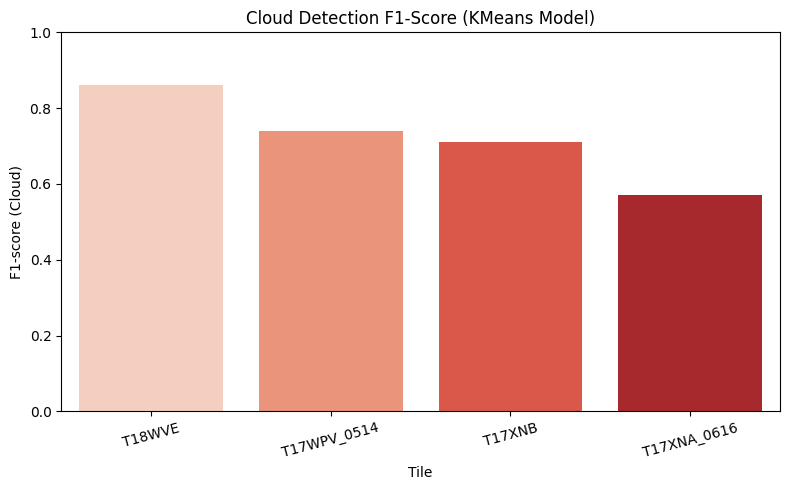

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=df_cloud, x="Tile", y="F1-score", palette="Reds")
plt.title("Cloud Detection F1-Score (KMeans Model)")
plt.ylim(0, 1)
plt.ylabel("F1-score (Cloud)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio

def overlay_kmeans_predictions(tile_id, date_str, kmeans_model, band_dir):
    """
    Display RGB image with red overlay showing predicted cloud patches (KMeans).
    Assumes Sentinel-2 B04 (red), B03 (green), B02 (blue) are used.
    """
    # Load RGB bands
    band_paths = [
        os.path.join(band_dir, f"{tile_id}_{date_str}_B04_10m.jp2"),  # red
        os.path.join(band_dir, f"{tile_id}_{date_str}_B03_10m.jp2"),  # green
        os.path.join(band_dir, f"{tile_id}_{date_str}_B02_10m.jp2"),  # blue
    ]

    rgb_bands = []
    for path in band_paths:
        if not os.path.exists(path):
            print(f"❌ Missing band: {path}")
            return
        with rasterio.open(path) as src:
            rgb_bands.append(src.read(1))

    # Create RGB composite (normalize + clip)
    rgb = np.stack(rgb_bands, axis=-1).astype(np.float32)
    rgb /= np.percentile(rgb, 99)
    rgb = np.clip(rgb, 0, 1)

    h, w, _ = rgb.shape
    patch_size = 64
    mask_pred = np.zeros((h, w), dtype=bool)

    # Predict cloud per patch
    for i in range(0, h - patch_size, patch_size):
        for j in range(0, w - patch_size, patch_size):
            patch = rgb[i:i+patch_size, j:j+patch_size, :]
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                continue
            feat = patch.mean(axis=(0, 1)).reshape(1, -1).astype(np.float32)
            pred = kmeans_model.predict(feat)[0]
            if pred == 0:  # cluster 0 = cloud
                mask_pred[i:i+patch_size, j:j+patch_size] = True

    # Create red overlay
    overlay = np.zeros_like(rgb)
    overlay[..., 0] = mask_pred.astype(float)  # red channel

    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb)
    plt.imshow(overlay, alpha=0.3)
    plt.title(f"{tile_id} – {date_str} (KMeans Cloud Detection)\nRed = Predicted Cloud")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
def get_y_true_and_pred(tile_id, date_str, label_filename, kmeans_model, band_dir, label_dir):
    # Load bands and label raster
    bands, label = load_bands_and_label(tile_id, date_str, label_filename, band_dir, label_dir)

    # Extract 64×64 patches that contain cloud/snow
    X_patches, y_labels = extract_clean_patches(bands, label, size=64)

    if len(X_patches) == 0:
        print(f"⚠ No valid patches in {tile_id}")
        return None, None

    # Get patch-mean reflectance (B02, B03, B04)
    X_feat = X_patches.mean(axis=(1, 2)).astype(np.float64)

    # Remap labels: 1 = cloud → 1, everything else → 0
    y_true = (y_labels == 1).astype(int)  # 1 = cloud, 0 = not cloud

    # Predict using KMeans: cluster 0 = cloud
    y_pred = (kmeans_model.predict(X_feat) == 0).astype(int)

    return y_true, y_pred

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_and_plot_confusion_kmeans(tile_id, date_str, label_file, kmeans_model, band_dir, label_dir):
    # Load bands and labels
    bands, label = load_bands_and_label(tile_id, date_str, label_file, band_dir, label_dir)

    # Extract patches and labels
    X_patches, y_labels = extract_clean_patches(bands, label, size=64)

    if len(X_patches) == 0:
        print(f"⚠ No valid patches found in {tile_id}")
        return

    # Get patch-mean reflectance & ensure float32 to match KMeans expectations
    X_features = X_patches.mean(axis=(1, 2)).astype(np.float32)

    # Binary labels: 1 = cloud, 0 = not-cloud
    y_true = (y_labels == 1).astype(int)

    # Predict with KMeans (assumes cluster 0 = cloud)
    y_pred = (kmeans_model.predict(X_features) == 0).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    labels = ["Not Cloud", "Cloud"]

    # Report
    print(f"📍 {tile_id} – {date_str}")
    print("📊 Confusion Matrix:")
    print(cm)
    print("\n📈 Classification Report (Cloud = 1):")
    print(classification_report(y_true, y_pred, target_names=labels))

    # Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=labels, yticklabels=labels)
    plt.title(f"{tile_id} – {date_str} (KMeans Cloud Detection)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_and_plot_confusion_kmeans(tile_id, date_str, label_file, kmeans_model, band_dir, label_dir):
    # --- Load bands and label raster ---
    bands, label = load_bands_and_label(tile_id, date_str, label_file, band_dir, label_dir)

    # --- Extract patches and their labels ---
    X_patches, y_labels = extract_clean_patches(bands, label, size=64)

    if len(X_patches) == 0:
        print(f"⚠ No valid patches found in {tile_id}")
        return

    # --- Compute patch-mean reflectance and cast to float64 to match model ---
    X_features = X_patches.mean(axis=(1, 2)).astype(np.float64)

    # --- True labels: 1 = cloud, 0 = not-cloud ---
    y_true = (y_labels == 1).astype(int)

    # --- Predict using KMeans (cluster 0 = cloud) ---
    y_pred = (kmeans_model.predict(X_features) == 0).astype(int)

    # --- Confusion Matrix & Classification Report ---
    cm = confusion_matrix(y_true, y_pred)
    labels = ["Not Cloud", "Cloud"]

    print(f"📍 {tile_id} – {date_str}")
    print("📊 Confusion Matrix:")
    print(cm)
    print("\n📈 Classification Report (Cloud = 1):")
    print(classification_report(y_true, y_pred, target_names=labels))

    # --- Plot the confusion matrix ---
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=labels, yticklabels=labels)
    plt.title(f"{tile_id} – {date_str} (KMeans Cloud Detection)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

📍 T18WVE – 20250324T170849
📊 Confusion Matrix:
[[  454  2603]
 [ 1669 13683]]

📈 Classification Report (Cloud = 1):
              precision    recall  f1-score   support

   Not Cloud       0.21      0.15      0.18      3057
       Cloud       0.84      0.89      0.86     15352

    accuracy                           0.77     18409
   macro avg       0.53      0.52      0.52     18409
weighted avg       0.74      0.77      0.75     18409



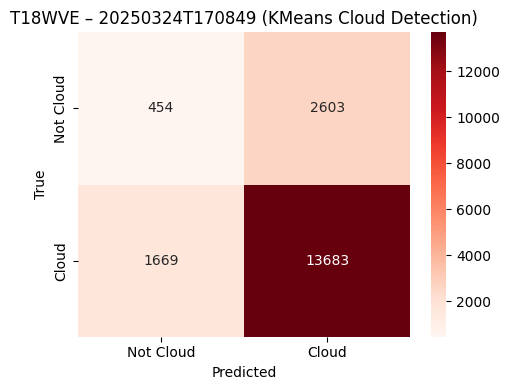

In [ ]:
evaluate_and_plot_confusion_kmeans("T18WVE", "20250324T170849", "T18WVE_ROI_FINAL.tif", kmeans, band_dir_val, label_dir_val)

📍 T17WPV – 20250514T172911
📊 Confusion Matrix:
[[ 245 1096]
 [ 460 2223]]

📈 Classification Report (Cloud = 1):
              precision    recall  f1-score   support

   Not Cloud       0.35      0.18      0.24      1341
       Cloud       0.67      0.83      0.74      2683

    accuracy                           0.61      4024
   macro avg       0.51      0.51      0.49      4024
weighted avg       0.56      0.61      0.57      4024



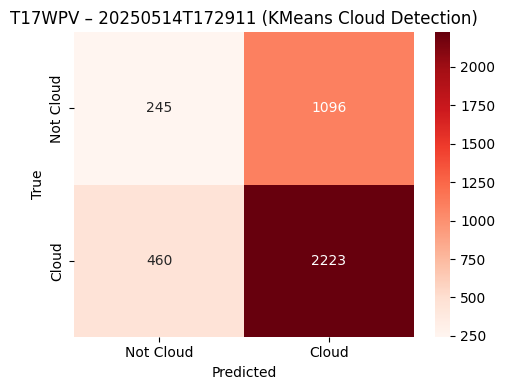

📍 T17XNB – 20250504T172921
📊 Confusion Matrix:
[[  77  692]
 [ 229 1130]]

📈 Classification Report (Cloud = 1):
              precision    recall  f1-score   support

   Not Cloud       0.25      0.10      0.14       769
       Cloud       0.62      0.83      0.71      1359

    accuracy                           0.57      2128
   macro avg       0.44      0.47      0.43      2128
weighted avg       0.49      0.57      0.51      2128



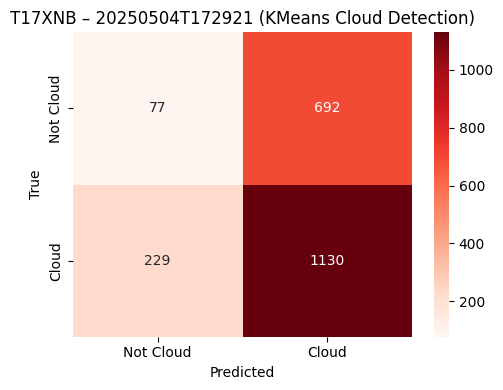

In [ ]:
evaluate_and_plot_confusion_kmeans("T17WPV", "20250514T172911", "T17WPV_FINAL.tif", kmeans, band_dir, label_dir)
evaluate_and_plot_confusion_kmeans("T17XNB", "20250504T172921", "T17XNB_ROI_FINAL.tif", kmeans, band_dir, label_dir)

In [ ]:
print("Cluster center dtype:", kmeans.cluster_centers_.dtype)

X_features = X_patches.mean(axis=(1, 2)).astype(np.float64)
y_pred = (kmeans.predict(X_features) == 0).astype(int)

Cluster center dtype: float64


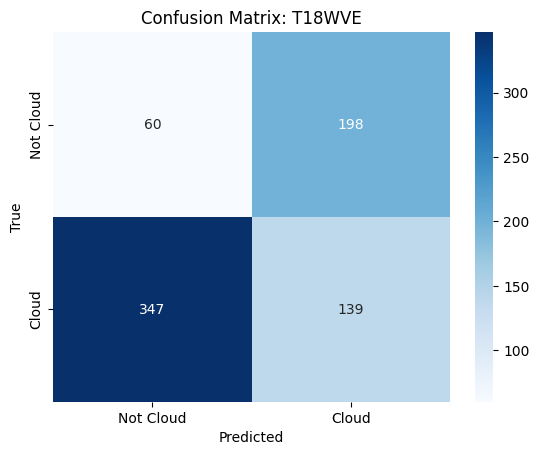

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Cloud", "Cloud"], yticklabels=["Not Cloud", "Cloud"])
plt.title(f"Confusion Matrix: {tile_id}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
usable_gt = (y_true == 0).sum()
usable_pred = (y_pred == 0).sum()
gain = usable_pred - usable_gt

print(f"Usable pixels (GT):    {usable_gt}")
print(f"Usable pixels (Pred):  {usable_pred}")
print(f"🟢 Gain in usable pixels: {gain}")

Usable pixels (GT):    258
Usable pixels (Pred):  407
🟢 Gain in usable pixels: 149


In [ ]:
def plot_confusion_matrix(tile_id, date_str, label_file, kmeans_model, band_dir, label_dir):
    # Load patches and labels
    bands, label = load_bands_and_label(tile_id, date_str, label_file, band_dir, label_dir)
    X_patches, y_labels = extract_clean_patches(bands, label, size=64)
    X_features = X_patches.mean(axis=(1, 2)).astype(np.float32)

    # Define binary true/predicted labels for cloud (1) vs not-cloud (0)
    y_true = (y_labels == 1).astype(int)
    y_pred = (kmeans_model.predict(X_features) == 0).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    labels = ["Not Cloud", "Cloud"]

    # Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=labels, yticklabels=labels)
    plt.title(f"{tile_id} – {date_str}\nCloud Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

<Axes: xlabel='Recall', ylabel='Precision'>

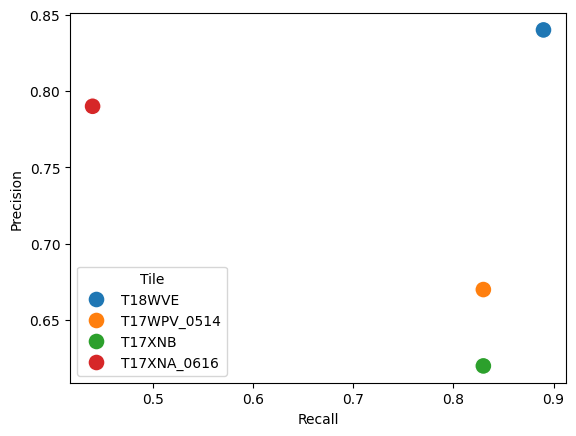

In [ ]:
sns.scatterplot(data=df_cloud, x="Recall", y="Precision", hue="Tile", s=150)

<BarContainer object of 2 artists>

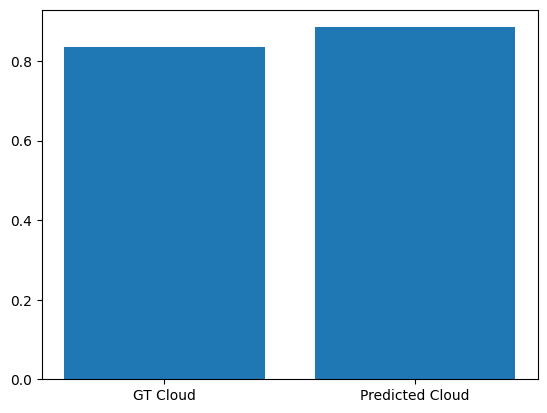

In [ ]:
band_dir_val = "/content/drive/MyDrive/Sentinel2_CloudProject/Validation"
label_dir_val = "/content/drive/MyDrive/Sentinel2_CloudProject/Validation"
y_true, y_pred = get_y_true_and_pred("T18WVE", "20250324T170849", "T18WVE_ROI_FINAL.tif", kmeans, band_dir_val, label_dir_val)

gt_frac = (y_true == 1).sum() / len(y_true)
pred_frac = (y_pred == 1).sum() / len(y_pred)

plt.bar(["GT Cloud", "Predicted Cloud"], [gt_frac, pred_frac])

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

# --- Config ---
tile_id = "T17XNA"
date_str = "20250409T172859"
bands_dir = "/content/drive/MyDrive/Sentinel2_CloudProject/Bands"
model_path = "/content/drive/MyDrive/Sentinel2_PondInlet_Exports/cnn_scl_model.h5"

# --- Load model ---
model = load_model(model_path)

# --- Load input bands ---
def read_band(tile, date, code, rescale=True):
    path = os.path.join(bands_dir, f"{tile}_{date}_{code}_10m.jp2")
    if not os.path.exists(path):  # Try 20m version if 10m doesn't exist
        path = path.replace("10m", "20m")
        with rasterio.open(path) as src:
            # Resample to 10m
            scale = 2
            data = src.read(
                out_shape=(
                    src.count,
                    int(src.height * scale),
                    int(src.width * scale)
                ),
                resampling=Resampling.bilinear
            )[0]
    else:
        with rasterio.open(path) as src:
            data = src.read(1)
    return data.astype(np.float32) / 10000

band_codes = ["B02", "B03", "B04", "B08", "B11", "B12"]
bands = [read_band(tile_id, date_str, code) for code in band_codes]
image_stack = np.stack(bands, axis=-1)

# --- Compute Brightness Index: B04 + B08 – B11 ---
brightness = image_stack[:, :, 2] + image_stack[:, :, 3] - image_stack[:, :, 4]

# --- Patch-wise Prediction for CNN with Conv layers (64×64×6 input) ---
def chunk_and_predict_cnn(image_stack, model, patch_size=64):
    H, W, C = image_stack.shape
    out_mask = np.zeros((H, W), dtype=np.uint8)

    for i in range(0, H - patch_size + 1, patch_size):
        for j in range(0, W - patch_size + 1, patch_size):
            patch = image_stack[i:i+patch_size, j:j+patch_size, :]
            patch = np.expand_dims(patch, axis=0)  # (1, 64, 64, 6)
            pred = model.predict(patch, verbose=0)  # Output: (1, 64, 64, num_classes)
            pred_mask = np.argmax(pred[0], axis=-1)  # (64, 64)
            out_mask[i:i+patch_size, j:j+patch_size] = pred_mask

    return out_mask

# Run prediction
cnn_mask = chunk_and_predict_cnn(image_stack, model)


# --- FCA: False Clouds on Snow ---
snow_mask = (brightness > 0.55)
cloud_mask = (cnn_mask == 8)     # class 8 = cloud

snow_pixels = np.sum(snow_mask)
false_clouds_on_snow = np.sum(snow_mask & cloud_mask)
fca = false_clouds_on_snow / snow_pixels

# --- CPGI: Clear Pixel General Improvement ---
clear_mask = (brightness < 0.3)
agree_mask = clear_mask & (cnn_mask == 4)  # class 4 = vegetation/clear land
cpgi = (np.sum(agree_mask) / np.sum(clear_mask)) - 0.9

# --- Print Results ---
print(f"Tile: {tile_id} ({date_str})")
print(f"FCA (False Clouds on Snow): {fca:.4f}")
print(f"CPGI (Clear Pixel General Improvement): {cpgi:.4f}")

Tile: T17XNA (20250409T172859)
FCA (False Clouds on Snow): 0.0000
CPGI (Clear Pixel General Improvement): -0.9000


In [ ]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

# --- Config ---
tile_id = "T17WPV"
date_str = "20250322T172031"
bands_dir = "/content/drive/MyDrive/Sentinel2_CloudProject/Bands"
model_path = "/content/drive/MyDrive/Sentinel2_PondInlet_Exports/cnn_scl_model.h5"

# --- Load model ---
model = load_model(model_path)

# --- Load input bands ---
def read_band(tile, date, code, rescale=True):
    path = os.path.join(bands_dir, f"{tile}_{date}_{code}_10m.jp2")
    if not os.path.exists(path):  # Try 20m version if 10m doesn't exist
        path = path.replace("10m", "20m")
        with rasterio.open(path) as src:
            # Resample to 10m
            scale = 2
            data = src.read(
                out_shape=(
                    src.count,
                    int(src.height * scale),
                    int(src.width * scale)
                ),
                resampling=Resampling.bilinear
            )[0]
    else:
        with rasterio.open(path) as src:
            data = src.read(1)
    return data.astype(np.float32) / 10000

band_codes = ["B02", "B03", "B04", "B08", "B11", "B12"]
bands = [read_band(tile_id, date_str, code) for code in band_codes]
image_stack = np.stack(bands, axis=-1)

# --- Compute Brightness Index: B04 + B08 – B11 ---
brightness = image_stack[:, :, 2] + image_stack[:, :, 3] - image_stack[:, :, 4]

# --- Patch-wise Prediction for CNN with Conv layers (64×64×6 input) ---
def chunk_and_predict_cnn(image_stack, model, patch_size=64):
    H, W, C = image_stack.shape
    out_mask = np.zeros((H, W), dtype=np.uint8)

    for i in range(0, H - patch_size + 1, patch_size):
        for j in range(0, W - patch_size + 1, patch_size):
            patch = image_stack[i:i+patch_size, j:j+patch_size, :]
            patch = np.expand_dims(patch, axis=0)  # (1, 64, 64, 6)
            pred = model.predict(patch, verbose=0)  # Output: (1, 64, 64, num_classes)
            pred_mask = np.argmax(pred[0], axis=-1)  # (64, 64)
            out_mask[i:i+patch_size, j:j+patch_size] = pred_mask

    return out_mask

# Run prediction
cnn_mask = chunk_and_predict_cnn(image_stack, model)


# --- FCA: False Clouds on Snow ---
snow_mask = (brightness > 0.55)
cloud_mask = (cnn_mask == 8)     # class 8 = cloud

snow_pixels = np.sum(snow_mask)
false_clouds_on_snow = np.sum(snow_mask & cloud_mask)
fca = false_clouds_on_snow / snow_pixels

# --- CPGI: Clear Pixel General Improvement ---
clear_mask = (brightness < 0.3)
agree_mask = clear_mask & (cnn_mask == 4)  # class 4 = vegetation/clear land
cpgi = (np.sum(agree_mask) / np.sum(clear_mask)) - 0.9

# --- Print Results ---
print(f"Tile: {tile_id} ({date_str})")
print(f"FCA (False Clouds on Snow): {fca:.4f}")
print(f"CPGI (Clear Pixel General Improvement): {cpgi:.4f}")

Tile: T17WPV (20250322T172031)
FCA (False Clouds on Snow): 0.0000
CPGI (Clear Pixel General Improvement): -0.9000
